In [1]:
from apikeyspath import PATH_TO_REPO
import pandas as pd
import pickle
import numpy as np
from sklearn.cross_validation import cross_val_score
import matplotlib
from matplotlib import pyplot as plt  
from matplotlib import rc
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sb
from pylab import rcParams
from sklearn.metrics import confusion_matrix
from matplotlib import cm

## Visualizations and Data and Model Exploration 

Let's visualize and explore some of our data and the model.

In [2]:
data = pd.read_pickle(PATH_TO_REPO + "data/clean_nyt_training_data.pkl")

label_dict = {0: "Arts", 1: "Business", 2: "Food", 3: "Health", 4: "NY", 5: "Politics", 6: "RealEstate", 7: "Science", \
             8: "Sports", 9: "Style", 10: "Tech", 11: "Travel", 12: "US", 13: "World"}

### 1. Absolute number of samples

How many article samples do we have?

In [3]:
len(data)

115327

#### We have 115.327 article samples.

### 2. Number of samples per category

How many samples do we have per category?

In [4]:
data["category"] = data["label"].apply(lambda x: label_dict[x])

In [5]:
plot1data = data["label"].value_counts()
plot1frame = pd.DataFrame(plot1data)
plot1frame.rename(columns={0: 'Counts'}, inplace=True)
plot1frame = plot1frame.reset_index()
plot1frame.rename(columns={'index': 'label'}, inplace=True)
plot1frame["category"] = plot1frame["label"].apply(lambda x: label_dict[x])

In [6]:
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14) 
rcParams['figure.figsize'] = 13, 10

(0, 10500)

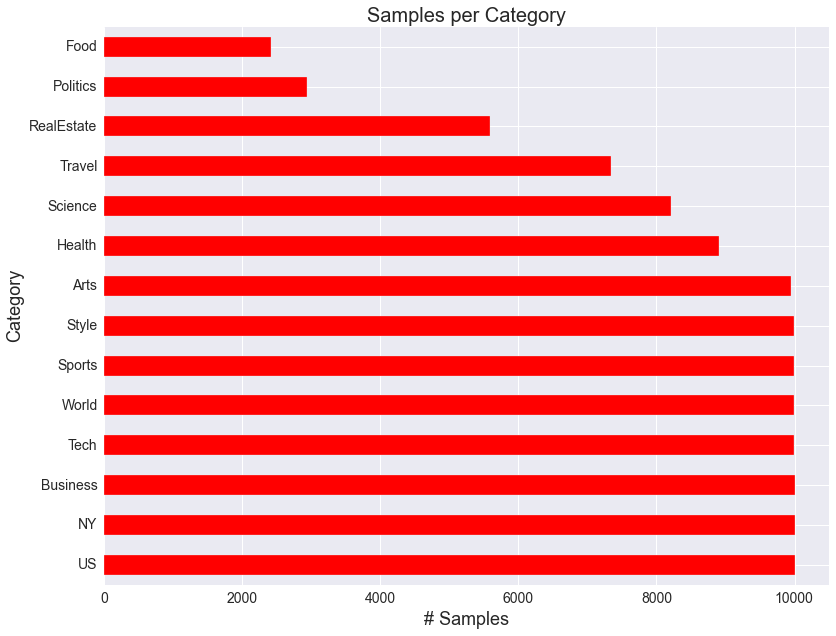

In [7]:
plot1frame.plot(x="category", y="Counts", kind='barh', rot=0, color="r")
plt.title('Samples per Category', fontsize=20)
plt.ylabel('Category', fontsize=18)
plt.xlabel('# Samples', fontsize=18)
ax = plt.gca()
ax.legend_ = None
ax.set_xlim([0, 10500])

### 3. Histogram with wordnumbers, stacked per label

Samples are strings, which are a bunch of words gathered from an article's **headline**, its **lead paragraph**, its **keyword list**, and a **snippet** from its text. So, how long are those sample typically? Let's make a histogram of how often certain numbers of words appear for the different sections.

In [8]:
plot2frame = pd.DataFrame()
for key, value in label_dict.iteritems():
    plot2frame[value] = data[data["label"]==key]["length"].value_counts()
plot2frame = plot2frame.sort_index()

(0, 150)

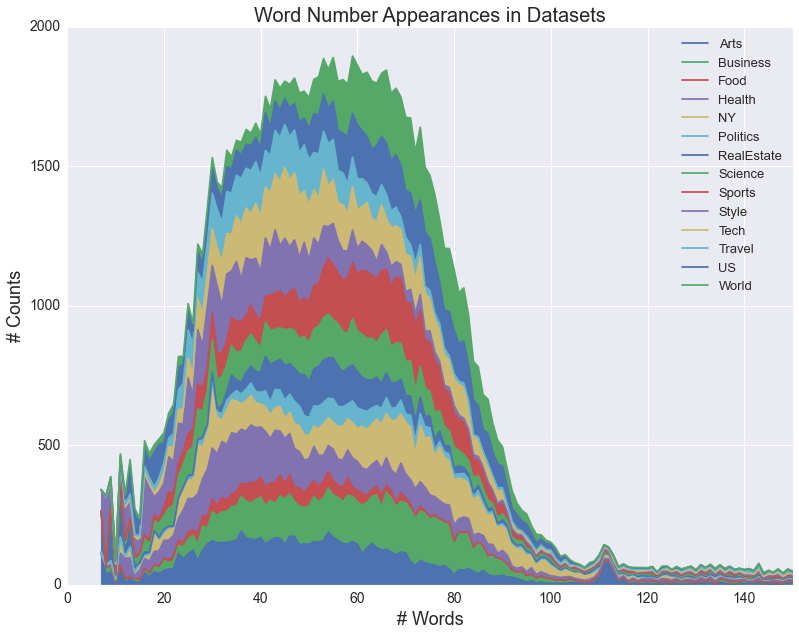

In [9]:
plot2frame.plot(kind='area')
plt.title('Word Number Appearances in Datasets', fontsize=20)
plt.ylabel('# Counts', fontsize=18)
plt.xlabel('# Words', fontsize=18)
ax = plt.gca()
ax.legend(fontsize=13)
ax.set_xlim([0, 150])

### 4. The Logistic Regression Model - Coefficients

Let's now have a closer look on our Logistic Regression model. It's interesting to see which are the most decisive words for the different categories. Let's plot them.

In [10]:
model = pickle.load(open(PATH_TO_REPO + "data/log_regression_model.pkl"))

In [11]:
tfidf = pickle.load(open(PATH_TO_REPO + "data/tfidf_vectorizer.pkl"))

In [12]:
rc('xtick', labelsize=18) 
rc('ytick', labelsize=18) 

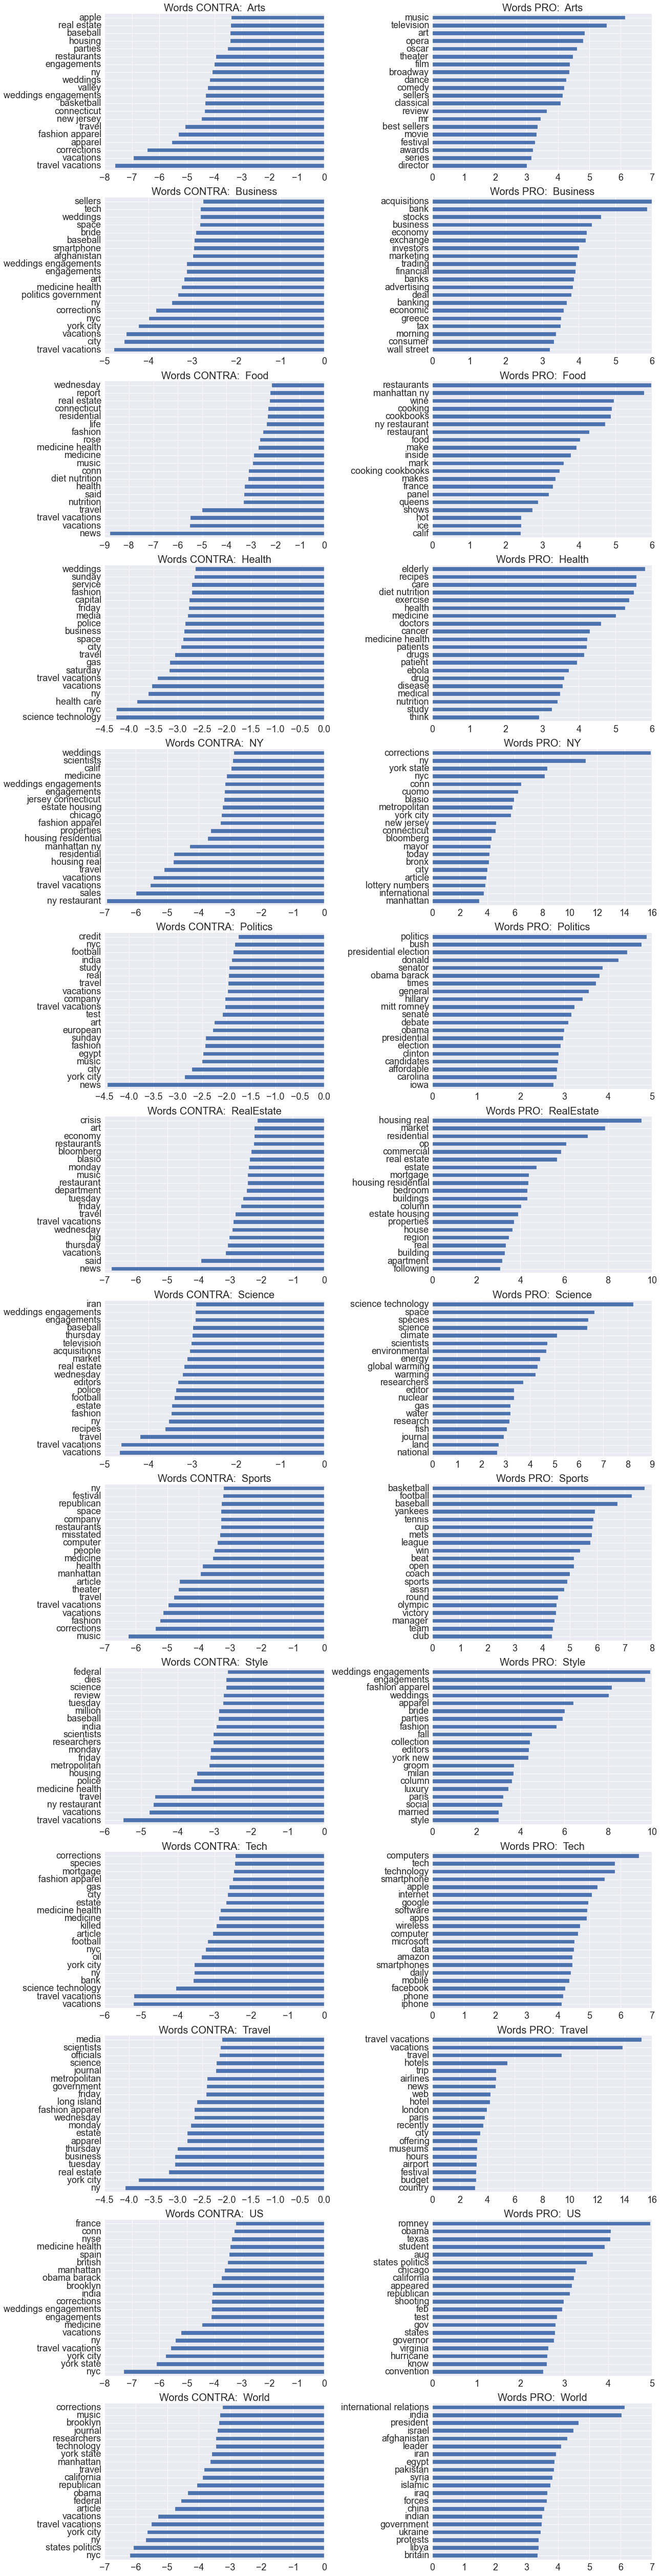

In [13]:
fig, axes = plt.subplots(14, 2, figsize=(18,70))
for key, value in label_dict.iteritems():
    coef = pd.Series(model.coef_[key], index=tfidf.get_feature_names())
    coef.sort()   
    coef[:20].plot(kind='barh', ax=axes[key,0])
    coef[-20:].plot(kind='barh', ax=axes[key,1])
    f = axes[key, 0].set_title("Words CONTRA:  " + value, fontsize = 20)
    f = axes[key, 1].set_title("Words PRO:  " + value, fontsize = 20)
f = plt.tight_layout()

### 5. The Logistic Regression Model - Scores

Okay, but what about scores?

In [14]:
X, y = tfidf.fit_transform(data.allwords).todense(), data.label

In [15]:
cross_val_score(model, X, y, cv=4, scoring='accuracy').mean()

0.74951213095690239

**Accuracy: 75% **

In [16]:
-cross_val_score(model, X, y, cv=4, scoring='log_loss').mean()

0.83544833409640629

**Logloss: 0.835**

### Let's compare these to the naive baselines. Naive baselines are:

## Accuracy

Just predict randomly, hence 1/14 = 0.07 chance to hit correctly. 

#### **Therefore, accuracy naive baseline: 0.07**

## Logloss

Multi Class Log Loss is defined as

$$logloss = -\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^M y_{i,j} \log(p_{i,j})$$

for N samples and M different classes.

So, assume we just predict randomly. Then $p_{i,j} = 0.07$ and $\log(p_{i,j}) = -2.64$ for all i and j. 

$y_{i,j}$ is one whenever it's real label for sample i does not correspond to the index j. In these cases we use $\log(p_{i,j})$ as penalty in the logloss. Hence, in our situation it is in 13 out of 14 cases one. Otherwise, it's zero. Then we sum over all samples but normalize with the total number of samples. Hence, the logloss for random prediction would be -13 * -2.64 = 34.30 

#### **Therefore, logloss naive baseline: 34.30**

## Our Scores

Seems like we are doing not too bad. Predicting correctly in about 75% of all cases seems good when having 14 different labels. Similarly, a logloss of 0.835 also seems quite good compared to the baseline.

### 6. The Logistic Regression Model - Confusion Matrix

Let's have a look at the confusion matrix.

In [17]:
y_true = y
y_pred = model.predict(X)

In [18]:
cmatrix = confusion_matrix(y_true, y_pred)
print cmatrix

[[7934  162   14   53  350   11   17  166  289  206  154   62  322  204]
 [ 348 6883   14  187  100   33   95  181  130  128  913   71  407  509]
 [  45   34 1836   78  135    4    7   52   31  103   16   21   37   21]
 [  97  155   87 7091   88   22   10  631   90  151  106   21  242  112]
 [ 539  148  177  100 7381   29  308  150  208  166   93   55  415  230]
 [  23   76    0   38   51 1502    3   25   14    8   23    2 1068  113]
 [  42   93    0   10  244    0 5075   26    9   25   16   15   35    4]
 [ 197  225   13  834  191   14   28 5635  129  100  196   49  357  239]
 [ 138   92    3   39  100    3    7   79 9085   74   35   11  175  153]
 [ 439  120  172  215  315    9   40  144  160 7802  199  112  193   69]
 [ 170  762   11   94   58   14   16  173   90  100 7977   61  233  239]
 [ 274   72   33   29   95    3   19   83   74  152   80 6245   96   82]
 [ 363  484   14  275  361  549   35  407  270  141  201   54 6118  728]
 [ 212  484   12  118   89   34   21  200  159   96

Well, this looks ugly, let's plot it in colors.

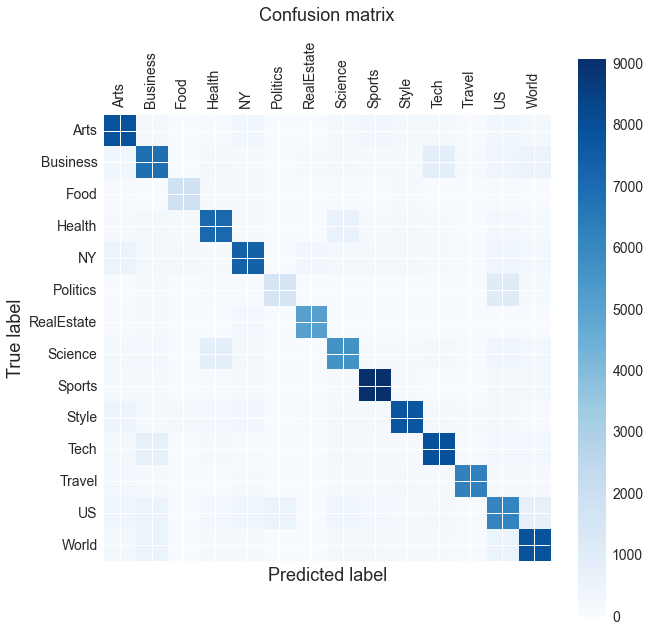

In [19]:
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14) 
rcParams['figure.figsize'] = 13, 10
plt.matshow(cmatrix, cmap=cm.Blues)
plt.title('Confusion matrix', fontsize=18, y=1.2)
plt.colorbar(cmap=cm.Blues)
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.xticks(np.arange(0, 14, 1), rotation=90)
plt.yticks(np.arange(0, 14, 1))
ax = plt.gca()
labels = [item.get_text() for item in ax.get_xticklabels()]
for key, val in label_dict.iteritems():
    labels[int(key)] = val
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()

This does not look too bad. Note that in the cases for "Food" and "Politics" there are simply significantly less samples overall. Therefore, they appear lighter in the plot. This does not mean they are predicted worse than the others.